In [1]:
import torch.utils.data as data
from torch.utils.data import DataLoader
import os
import glob
import torch
import pathlib
from torchvision import transforms
from matplotlib import pyplot as plt
from pathlib import Path
import PIL.Image
from torchvision.transforms import v2

# modified from https://discuss.pytorch.org/t/loading-ade20k-dataset/48684/2
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','training','0Probe','*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
             # we use `pathlib.Path(img_path).stem` to extract only the file name
             self.mask_files.append(os.path.join(folder_path,'annotations','training','0Probe',pathlib.Path(img_path).stem + ".png")) 

        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])

        # From PIL image to tensor and normalization:
        self.trans = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32,scale=True),
            v2.Resize(size=(320,320)),
            v2.Normalize(mean,std)
        ])

    def __getitem__(self, index, observe=False):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = PIL.Image.open(img_path)
            label = PIL.Image.open(mask_path)
            if observe is True:
                # Displaying images (optional for debugging)
                print(f'original size of images:',data.size, label.size)  # Check image dimensions
                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(data)
                
                plt.subplot(1,2,2)
                plt.imshow(label)
                plt.tight_layout()
                plt.show()
            return self.trans(data), self.trans(label)

    def __len__(self):
        return len(self.img_files)


In [11]:
folder_path = Path('./data/mseg_dataset/ADEChallengeData2016')
print(f"File exists: {folder_path.exists()}")

loader = DataLoaderSegmentation(folder_path=folder_path)
data_loader = DataLoader(loader,num_workers=4, batch_size=1, shuffle=False, pin_memory=True)


File exists: True


original size of images: (683, 512) (683, 512)


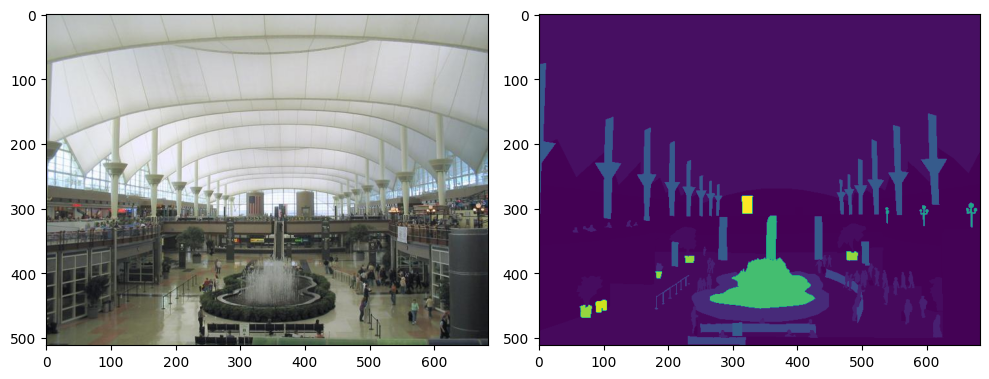

original size of images: (711, 512) (711, 512)


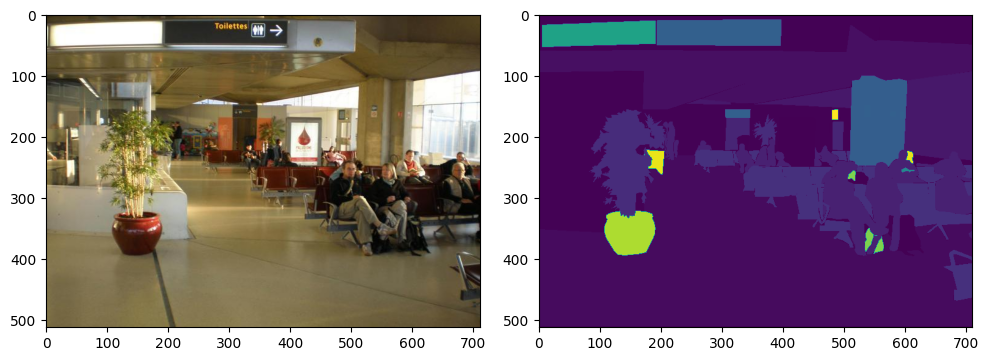

size after passing through __getitem__ -> original image:  torch.Size([3, 320, 320]) | annotated image:  torch.Size([3, 320, 320])


In [24]:
image_loader, label_loader = loader.__getitem__(0,observe=True)
image_loader, label_loader = loader.__getitem__(1,observe=True)
print('size after passing through __getitem__ -> original image: ',image_loader.shape, '| annotated image: ',label_loader.shape)

In [13]:
for foo, bar in data_loader:
    print(foo.shape, bar.shape)

total_size = len(loader)
print(f"Total size of the dataset: {total_size}")


torch.Size([1, 3, 320, 320]) torch.Size([1, 3, 320, 320])
torch.Size([1, 3, 320, 320]) torch.Size([1, 3, 320, 320])
Total size of the dataset: 2


In [16]:
# define my dense prediction transformer (DPT) class
import lightning as L
import torch.nn as nn
import torch
import sys
sys.path.append(os.path.join(os.getcwd(), "DPT"))  
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from DPT import DPT


class LightningModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DPT()
        self.max_epochs = 100
        self.loss_fn = nn.MSELoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, idx):
        images, annotations = batch
        predictions = self(images) # these are raw logits 
        #predictions = torch.softmax(predictions,dim=1)
        loss = self.loss_fn(predictions,annotations)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # paper: with momentum 0.9 and a polynomial learning rate scheduler with decay factor 0.9
        optimizer = torch.optim.SGD(self.parameters(), lr=0.002, momentum=0.9,weight_decay=1e-4)
        
        # Scheduler taken from https://github.com/rzhao5659/2024-LSeg/blob/main/test/test_dpt.ipynb
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: pow(1.0 - epoch / self.max_epochs, 0.9)
        )
        return [optimizer], [lr_scheduler]

my_dpt = LightningModel()

# this part was taken from https://github.com/rzhao5659/2024-LSeg/blob/main/test/test_dpt.ipynb
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",  # Metric to monitor
    mode="min",  # Save the model with the minimum training loss
    save_top_k=1,  # Only keep the best model
    filename="epoch={epoch}-train_loss={train_loss:.4f}",  # Filename format
    verbose=False,
)


trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=1, log_every_n_steps=1, callbacks=[checkpoint_callback])
trainer.fit(model=my_dpt, train_dataloaders=data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | DPT     | 326 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
326 M     Trainable params
410 K     Non-trainable params
326 M     Total params
1,307.059 Total estimated model params size (MB)
400       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s, v_num=13]


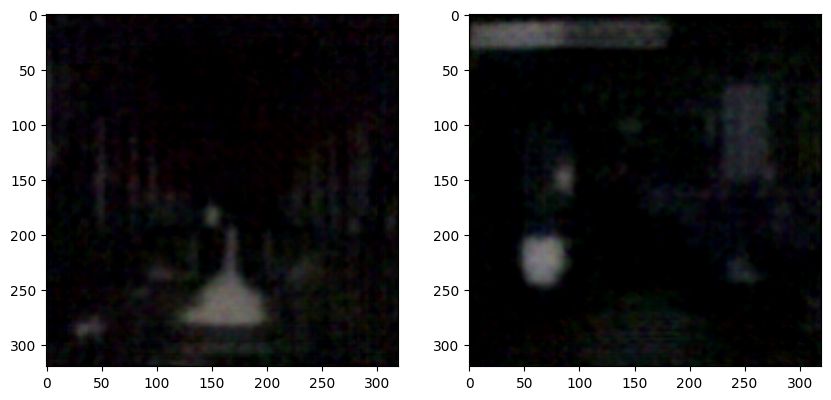

In [32]:
from torchvision.transforms import v2

def tensor_to_PIL(img):
    # From tensor to image:
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    denormalize = v2.Compose([
        v2.Lambda(lambda x: x * std[:, None, None] + mean[:, None, None]),  # Apply inverse normalization
        v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # Ensure values are within [0, 1]
        v2.ToPILImage()  # Convert tensor to PIL Image for visualization
    ])
    return denormalize(img)

with torch.no_grad():
    my_dpt.eval()
    plt.figure(figsize=(10,5))
    idx = 1
    for img_tensor, label_tensor in data_loader:
        pred_tensor = my_dpt(img_tensor)
        pred_img_mask = pred_tensor.squeeze(0)
        to_image = tensor_to_PIL(pred_img_mask)
        plt.subplot(1,2,idx)
        plt.imshow(to_image)
        idx += 1 

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.imshow(data)

# plt.subplot(1,2,2)
# plt.imshow(label)
# plt.tight_layout()
# plt.show()
